In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#from matplotlib import style
#style.use('fivethirtyeight')
import seaborn as sns
#sns.set(style = 'white', color_code=True)
# import warnings
# warnings.filterwarnings('ignore')
# sns.set_style('whitegrid')

from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Performing grid search
# from sklearn.model_selection import GridSearchCV
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
df = pd.concat([train,test],ignore_index=False)

In [4]:
df.reset_index(drop=True, inplace=True)

In [5]:
df["Gender"].fillna(value="other", inplace=True)
df["Genderc"]=df["Gender"].astype("category")
df["Genderc"]=df["Genderc"].cat.rename_categories([1,2,3])
df=df.drop("Gender", axis=1)

In [6]:
df["Married"].fillna(value="No", inplace=True)
df["Marriedc"]=df["Married"].astype("category")
df["Marriedc"]=df["Marriedc"].cat.rename_categories([1,2])
df=df.drop("Married", axis=1)

In [7]:
df["Dependents"].fillna(value="0", inplace=True)
df["Dependentsc"]=df["Dependents"].astype("category")
df["Dependentsc"]=df["Dependentsc"].cat.rename_categories([1,2,3,4])
df=df.drop("Dependents", axis=1)

In [8]:
df["Educationc"]=df["Education"].astype("category")
df["Educationc"]=df["Educationc"].cat.rename_categories([1,2])
df=df.drop("Education", axis=1)

In [9]:
df["Self_Employed"].fillna(value="other", inplace=True)
df["Self_Employedc"]=df["Self_Employed"].astype("category")
df["Self_Employedc"]=df["Self_Employedc"].cat.rename_categories([1,2,3])
df=df.drop("Self_Employed", axis=1)

In [10]:
df["Property_Areac"]=df["Property_Area"].astype("category")
df["Property_Areac"]=df["Property_Areac"].cat.rename_categories([1,2,3])
df=df.drop("Property_Area", axis=1)


df["Credit_History"].fillna(value=1, inplace=True)
df["Credit_Historyc"]=df["Credit_History"].astype("category")
df=df.drop("Credit_History", axis=1)

In [11]:
df["ApplicantIncome"]=df["ApplicantIncome"].astype("object")
df["CoapplicantIncome"]=df["CoapplicantIncome"].astype("object")


# df["LoanAmount"]=df["LoanAmount"].fillna(df["LoanAmount"].mean())
# df["LoanAmount"]=df["LoanAmount"].astype("object")
impute_grps = df.pivot_table(values=["LoanAmount"], index=["Genderc","Marriedc","Self_Employedc"], aggfunc=np.mean)
def num_missing(x):
  return sum(x.isnull())

#iterate only through rows with missing LoanAmount
for i,row in df.loc[df['LoanAmount'].isnull(),:].iterrows():
    ind = tuple([row['Genderc'],row['Marriedc'],row['Self_Employedc']])
    df.loc[i,'LoanAmount'] = impute_grps.loc[ind].values[0]
df["LoanAmount"]=df["LoanAmount"].astype("object")


df["Loan_Amount_Term"]=df["Loan_Amount_Term"].fillna(df["Loan_Amount_Term"].mean())
df["Loan_Amount_Term"]=df["Loan_Amount_Term"].astype("object")

In [12]:
df.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_ID,Loan_Status,Genderc,Marriedc,Dependentsc,Educationc,Self_Employedc,Property_Areac,Credit_Historyc
0,5849,0,127.098,360,LP001002,Y,2,1,1,1,1,3,1.0
1,4583,1508,128,360,LP001003,N,2,2,2,1,1,1,1.0
2,3000,0,66,360,LP001005,Y,2,2,1,1,2,3,1.0
3,2583,2358,120,360,LP001006,Y,2,2,1,2,1,3,1.0
4,6000,0,141,360,LP001008,Y,2,1,1,1,1,3,1.0


In [13]:
from sklearn.preprocessing import scale
e=pd.Series(data=10.5, index=range(0,981))
a = df["LoanAmount"].multiply(9.5*1000)
b=a.multiply(e.pow((df["Loan_Amount_Term"].divide(12))))
d=e.pow((df["Loan_Amount_Term"].divide(12).subtract(1)))
EMI=b.divide(d)

In [14]:
# df.reset_index()
df["sum_Income"]=df["ApplicantIncome"].add(df["CoapplicantIncome"])
df["Poly_feature"]=EMI.divide((df["sum_Income"]))
df["ratio"]=df["sum_Income"].divide(df["LoanAmount"])

In [15]:
df.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_ID,Loan_Status,Genderc,Marriedc,Dependentsc,Educationc,Self_Employedc,Property_Areac,Credit_Historyc,sum_Income,Poly_feature,ratio
0,5849,0,127.098,360,LP001002,Y,2,1,1,1,1,3,1.0,5849,2167.55,46.0197
1,4583,1508,128,360,LP001003,N,2,2,2,1,1,1,1.0,6091,2096.21,47.5859
2,3000,0,66,360,LP001005,Y,2,2,1,1,2,3,1.0,3000,2194.5,45.4545
3,2583,2358,120,360,LP001006,Y,2,2,1,2,1,3,1.0,4941,2422.59,41.175
4,6000,0,141,360,LP001008,Y,2,1,1,1,1,3,1.0,6000,2344.12,42.5532


In [16]:
df["Poly_feature"]=scale(df["Poly_feature"])
df["sum_Income"]=scale(df["sum_Income"])
df["LoanAmount"]=scale(df["LoanAmount"])
df["Loan_Amount_Term"]=scale(df["Loan_Amount_Term"])
df["ratio"]=scale(df["ratio"])

C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with i

In [17]:
df.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_ID,Loan_Status,Genderc,Marriedc,Dependentsc,Educationc,Self_Employedc,Property_Areac,Credit_Historyc,sum_Income,Poly_feature,ratio
0,5849,0,-0.201843,0.276368,LP001002,Y,2,1,1,1,1,3,1.0,-0.154913,-0.266770,-0.119352
1,4583,1508,-0.190023,0.276368,LP001003,N,2,2,2,1,1,1,1.0,-0.114719,-0.345676,-0.077184
2,3000,0,-1.002189,0.276368,LP001005,Y,2,2,1,1,2,3,1.0,-0.628099,-0.236962,-0.134568
3,2583,2358,-0.294819,0.276368,LP001006,Y,2,2,1,2,1,3,1.0,-0.305721,0.015308,-0.249788
4,6000,0,-0.019730,0.276368,LP001008,Y,2,1,1,1,1,3,1.0,-0.129833,-0.071472,-0.212683


In [18]:
df_train=df[df.Loan_Status.notnull()]
df_test=df[df.Loan_Status.isnull()]

In [19]:
df_train.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_ID,Loan_Status,Genderc,Marriedc,Dependentsc,Educationc,Self_Employedc,Property_Areac,Credit_Historyc,sum_Income,Poly_feature,ratio
0,5849,0,-0.201843,0.276368,LP001002,Y,2,1,1,1,1,3,1.0,-0.154913,-0.266770,-0.119352
1,4583,1508,-0.190023,0.276368,LP001003,N,2,2,2,1,1,1,1.0,-0.114719,-0.345676,-0.077184
2,3000,0,-1.002189,0.276368,LP001005,Y,2,2,1,1,2,3,1.0,-0.628099,-0.236962,-0.134568
3,2583,2358,-0.294819,0.276368,LP001006,Y,2,2,1,2,1,3,1.0,-0.305721,0.015308,-0.249788
4,6000,0,-0.019730,0.276368,LP001008,Y,2,1,1,1,1,3,1.0,-0.129833,-0.071472,-0.212683


In [20]:
df_test.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_ID,Loan_Status,Genderc,Marriedc,Dependentsc,Educationc,Self_Employedc,Property_Areac,Credit_Historyc,sum_Income,Poly_feature,ratio
614,5720,0,-0.425813,0.276368,LP001015,NaN,2,2,1,1,1,3,1.0,-0.176338,-0.542480,0.041658
615,3076,1500,-0.216222,0.276368,LP001022,NaN,2,2,2,1,1,3,1.0,-0.366344,0.373690,-0.380570
616,5000,1800,0.857933,0.276368,LP001031,NaN,2,2,3,1,1,3,1.0,0.003038,0.710545,-0.478172
617,2340,2546,-0.556808,0.276368,LP001035,NaN,2,2,3,1,1,3,1.0,-0.314856,-0.406131,-0.042882
618,3276,0,-0.844995,0.276368,LP001051,NaN,2,1,1,2,1,3,1.0,-0.582259,-0.037324,-0.227577


In [21]:
df_test=df_test.drop("Loan_Status", axis=1)
key=df_test["Loan_ID"]
df_test=df_test.drop("Loan_ID", axis=1)
df_train=df_train.drop("Loan_ID", axis=1)

In [22]:
from sklearn.preprocessing import OneHotEncoder
enc=OneHotEncoder()
Xtrsp=pd.DataFrame(enc.fit_transform(df_train[["Genderc","Marriedc","Dependentsc","Educationc","Self_Employedc","Property_Areac", "Credit_Historyc"]]).toarray())
Xtstsp=pd.DataFrame(enc.transform(df_test[["Genderc","Marriedc","Dependentsc","Educationc","Self_Employedc","Property_Areac", "Credit_Historyc"]]).toarray())
Xtrsp.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [23]:
Xtstsp.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [24]:
df_train["Loan_Statusc"]=df_train["Loan_Status"].astype("category")
df_train["Loan_Statusc"]=df_train["Loan_Statusc"].cat.rename_categories([1,0])

#target variable
y_train=df_train["Loan_Statusc"]

#drop target variable from train dataset,this is our X_train
df_train=df_train.drop("Loan_Status", axis=1)
df_train=df_train.drop("Loan_Statusc", axis=1)

In [25]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
sel = SelectKBest(chi2, k=10)
Xtrsp=pd.DataFrame(sel.fit_transform(Xtrsp,y_train))
Xtstsp=pd.DataFrame(sel.transform(Xtstsp))

In [26]:
# Xtrsp
# Xtstsp

In [27]:
Xtrf=df_train[["Poly_feature","sum_Income","LoanAmount","Loan_Amount_Term","ratio"]]
Xtstf=df_test[["Poly_feature","sum_Income","LoanAmount","Loan_Amount_Term","ratio"]]

Xtrf.index=Xtrsp.index
X_train=pd.concat([Xtrsp,Xtrf], axis=1)
Xtstf.index=Xtstsp.index
X_test=pd.concat([Xtstsp,Xtstf], axis=1)

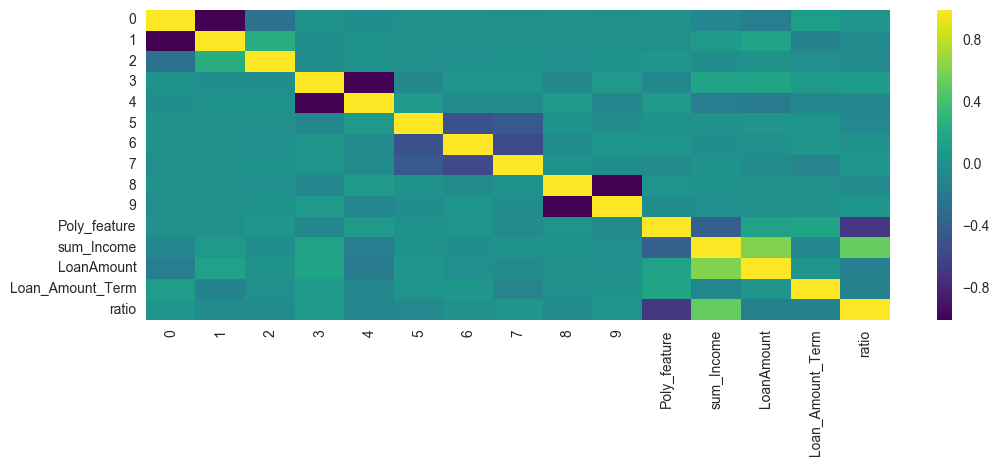

In [28]:
# X_train.head()
import seaborn as sns
corr_temp = X_train.corr()
sns.heatmap(corr_temp,cmap='viridis')

In [29]:
from sklearn.linear_model import LogisticRegression 
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.ensemble import RandomForestClassifier 
#from sklearn.naive_bayes import GaussianNB
#from sklearn.neural_network import MLPClassifier
#from sklearn.svm import LinearSVC

#model=RandomForestClassifier(n_estimators=128, verbose=1)
model=LogisticRegression(C=0.01, tol=0.00001)
#model=KNeighborsClassifier(n_neighbors=40)
#model=LinearSVC(C=0.01, tol=0.0000001)
#model=GaussianNB()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
print(y_pred)

[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0
 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 1 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [33]:
print(model.score(X_train,y_train))

0.758957654723


In [30]:
out=pd.DataFrame()
out["Loan_ID"]=key
out["Loan_Status"]=y_pred
out["Loan_Status"]=out["Loan_Status"].astype("category")
out["Loan_Status"]=out["Loan_Status"].cat.rename_categories(["Y","N"])
out.to_csv('outcredit.csv', index=False)


#from sklearn.cross_validation import train_test_split

#Xtr,Xts,ytr,yts=train_test_split(X_train,y_train, test_size=0.1)
#model.fit(Xtr, ytr)
#print model.score(Xts,yts)

In [31]:
# target = 'Loan_Status'
# IDcol = 'Loan_ID'
from sklearn.ensemble import GradientBoostingClassifier
# predictors = [x for x in df.columns if x not in [target, IDcol]]
#logReg = LogisticRegression(fit_intercept = False,C = 1e9)
#logReg = LogisticRegression(fit_intercept = False,C=0.01, tol=0.00001)
gb = GradientBoostingClassifier(learning_rate =0.1,random_state=10,subsample=0.8,n_estimators=20,max_features=3,
                                 max_depth=5,min_samples_leaf=13,min_samples_split=50)
gb.fit(X_train,y_train)
#print(logReg.coef_)
print(gb.get_params())
dtrain_predictions_gb = gb.predict(X_test)
gb.score(X_train,y_train)

{'loss': 'deviance', 'subsample': 0.8, 'min_samples_split': 50, 'min_weight_fraction_leaf': 0.0, 'max_depth': 5, 'verbose': 0, 'max_leaf_nodes': None, 'random_state': 10, 'max_features': 3, 'n_estimators': 20, 'min_samples_leaf': 13, 'warm_start': False, 'learning_rate': 0.1, 'init': None, 'presort': 'auto'}


0.82736156351791534

In [32]:
out=pd.DataFrame()
out["Loan_ID"]=key
out["Loan_Status"]=dtrain_predictions_gb
out["Loan_Status"]=out["Loan_Status"].astype("category")
out["Loan_Status"]=out["Loan_Status"].cat.rename_categories(["Y","N"])
out.to_csv('outcredit_gb.csv', index=False)